In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torchvision import datasets, transforms
from matplotlib.backends.backend_pdf import PdfPages
import operator
import matplotlib
matplotlib.rc('font', size=15)
from skimage.measure import compare_ssim as ssim
import argparse
import utils

# CREATE AN ARTIFICIAL ARGUMENT CLASS

In [2]:
class Args(object):
    def __init__(self):
        pass
    
args = Args()

# CHANGE THESE VARIABLES FOR DIFFERENT EXPERIMENTS

In [3]:
DATASET = 'xray' #'mnist' # 
DEMO = 'True' # 'True' 

NUM_MEASUREMENTS_LIST = [1000,4000]
BASIS_LIST = ['csdip','dct']#,'wavelet']

args.DATASET = DATASET
args.DEMO = DEMO

# CONSTRUCT AN ARTIFICIAL ARGUMENT OBJECT

In [4]:

if args.DATASET == 'mnist':
    args.IMG_SIZE = 28
    args.NUM_CHANNELS = 1
    args.DEMO = DEMO
    if DEMO == 'True':
        args.IMG_PATH = 'data/mnist_demo/'
    else:
        args.IMG_PATH = 'data/mnist/'
elif args.DATASET == 'xray':
    args.IMG_SIZE = 256
    args.NUM_CHANNELS = 1
    args.DEMO = DEMO
    if args.DEMO == 'True':
        args.IMG_PATH = 'data/xray_demo/'
    else:
        args.IMG_PATH = 'data/xray/'
else:
    raise NotImplementedError
    
if DEMO == 'True':
    args.MSE_PLOT_PATH = 'plots/{0}_demo_mse.pdf'.format(DATASET)
    args.REC_PLOT_PATH = 'plots/{0}_demo_reconstructions'.format(DATASET)
else:
    args.MSE_PLOT_PATH = 'plots/{0}_mse.pdf'.format(DATASET)
    args.REC_PLOT_PATH = 'plots/{0}_reconstructions'.format(DATASET)


# CREATE DATALOADER

In [5]:
dataloader = utils.get_data(args)

# LOAD RECONSTRUCTIONS AND COMPUTE MSE

In [6]:
RECONSTRUCTIONS = dict()
MSE = dict()
for BASIS in BASIS_LIST:
    RECONSTRUCTIONS[BASIS] = dict()
    MSE[BASIS] = dict()
    for NUM_MEASUREMENTS in NUM_MEASUREMENTS_LIST:
        RECONSTRUCTIONS[BASIS][NUM_MEASUREMENTS] = list()
        MSE[BASIS][NUM_MEASUREMENTS] = list()
        args.NUM_MEASUREMENTS = NUM_MEASUREMENTS
        args.BASIS = BASIS
        for _, (batch, _, im_path) in enumerate(dataloader):
            batch_ = batch.numpy()[0][0]
            rec_path = utils.get_path_out(args,im_path)
            rec = np.load(rec_path)
            n = rec.ravel().shape[0]
            mse = np.power(np.linalg.norm(batch_.ravel() - rec.ravel()),2)/(1.0*n)
            RECONSTRUCTIONS[BASIS][NUM_MEASUREMENTS].append(rec)
            MSE[BASIS][NUM_MEASUREMENTS].append(mse)

# SET VALUES FOR MARKERS IN PLOT

In [7]:
KWARGS_DICT = {'csdip':{"fmt":'r-', "label":'Ours', "marker":"^", "markersize":7,"capsize":4., "linewidth":1, "elinewidth":1},
              'dct':{"fmt":'g-', "label":'Lasso-DCT', "marker":"s", "markersize":7,"capsize":4., "linewidth":1, "elinewidth":1, "markerfacecolor":'None'},
              'wavelet':{"fmt":'b-', "label":'Lasso-DB4', "marker":"D", "markersize":7,"capsize":4., "linewidth":1, "elinewidth":1, "markerfacecolor":'None'}
              }

# PLOT MSE VALUES

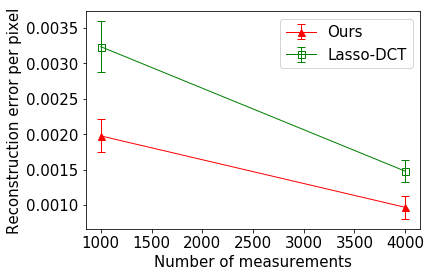

In [8]:
for BASIS in BASIS_LIST:
    kwargs = KWARGS_DICT[BASIS]
    y_temp = []
    y_error = []
    x_temp = NUM_MEASUREMENTS_LIST
    for NUM_MEASUREMENTS in NUM_MEASUREMENTS_LIST:
        n = len(MSE[BASIS][NUM_MEASUREMENTS])
        mse = np.mean(MSE[BASIS][NUM_MEASUREMENTS])
        error = np.std(MSE[BASIS][NUM_MEASUREMENTS]) / np.sqrt(1.0*n)
        y_temp.append(mse)
        y_error.append(error)
    plt.errorbar(x_temp,y_temp,y_error,**kwargs)
    
# plt.ylim([0,1.0])
plt.ylabel('Reconstruction error per pixel')
plt.xlabel('Number of measurements')
plt.legend(loc='upper right')

pdf_save_path = args.MSE_PLOT_PATH
pdf = PdfPages(pdf_save_path)
pdf.savefig(bbox_inches='tight')
pdf.close()

plt.show()

# PLOT RECONSTRUCTIONS

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


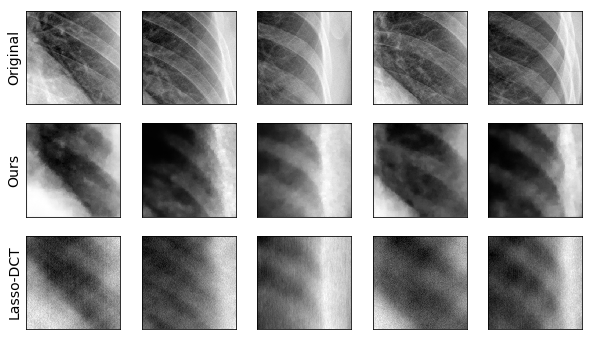

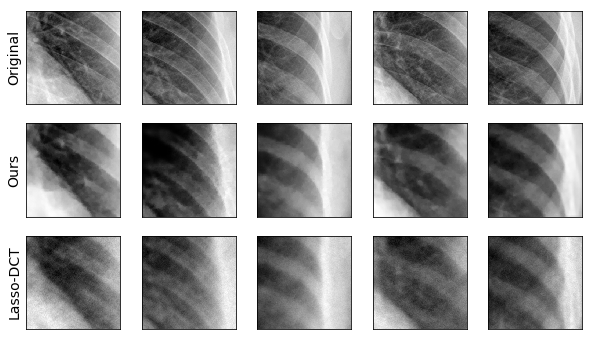

In [9]:
figure_height = 5

NUM_PLOT = 5
IMG_SIZE = args.IMG_SIZE
NUM_CHANNELS = args.NUM_CHANNELS
xx = range(NUM_PLOT)

def plot_image(image, cmap = None):
    frame=plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    frame = frame.imshow(image, cmap=cmap)

def renorm(x):
    return 0.5*x + 0.5


for NUM_MEASUREMENTS in NUM_MEASUREMENTS_LIST:
    fig = plt.figure(figsize=[2* NUM_PLOT, 2* figure_height])

    outer_counter = 0
    inner_counter = 0


    # Show original images
    outer_counter += 1
    for k, (batch, _ , im_path) in enumerate(dataloader):
        if k not in xx:
            continue
        inner_counter += 1
        ax = fig.add_subplot(figure_height, 1, outer_counter, frameon=False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel('Original', fontsize=14)
        _ = fig.add_subplot(figure_height, NUM_PLOT, inner_counter)
        plot_image(renorm(batch[0].cpu().numpy().reshape((IMG_SIZE,IMG_SIZE))), cmap='gray')

        if inner_counter == NUM_PLOT:
            break
    # plot reconstructions
    for i,BASIS in enumerate(BASIS_LIST):
        
        outer_counter += 1
        for k, image in enumerate(RECONSTRUCTIONS[BASIS][NUM_MEASUREMENTS]):
            if k not in xx:
                continue
            inner_counter += 1
            ax = fig.add_subplot(figure_height, 1, outer_counter, frameon=False)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_ticks([])
            ax.set_ylabel(KWARGS_DICT[BASIS]['label'], fontsize=14)
            _ = fig.add_subplot(figure_height, NUM_PLOT, inner_counter)
            plot_image(renorm(image.reshape(IMG_SIZE,IMG_SIZE)), cmap='gray')

            if inner_counter == (i+2)*NUM_PLOT:
                break

    
    pdf_save_path = '{0}_{1}.pdf'.format(args.REC_PLOT_PATH,NUM_MEASUREMENTS)
    pdf = PdfPages(pdf_save_path)
    pdf.savefig(bbox_inches='tight')
    pdf.close()
